In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb69/IMDB Dataset.csv


In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling sea

In [3]:
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer

In [4]:
df = pd.read_csv('/kaggle/input/imdb69/IMDB Dataset.csv')

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

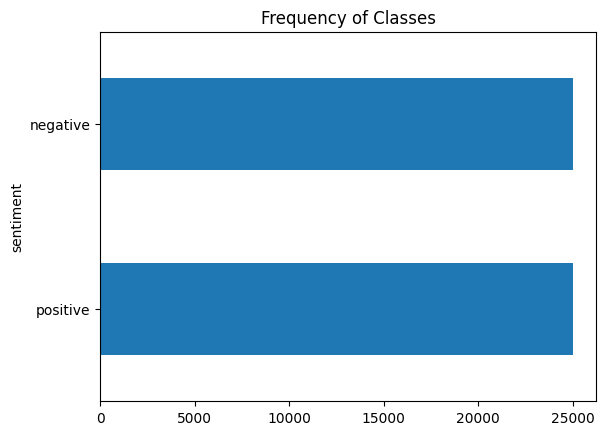

In [6]:
label_counts = df['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per review'}, xlabel='sentiment'>

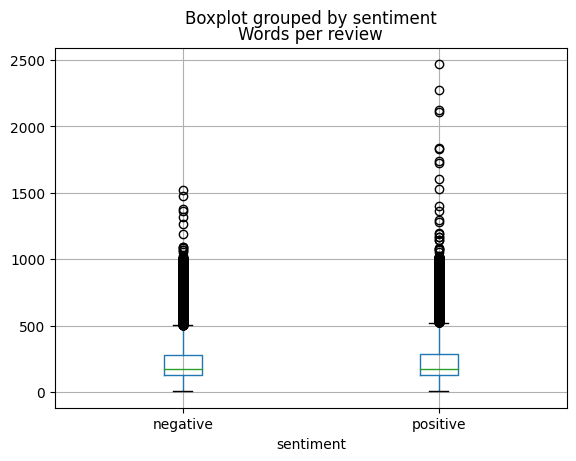

In [7]:
df['Words per review'] = df['review'].str.split().apply(len)
df.boxplot("Words per review", by="sentiment")

In [8]:
model_ckpt = "bert-base-uncased"  #ENGLISH english
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
text = "We love to sleep! Winters are awesome!"
encoded_text = tokenizer(text)
print(encoded_text)
len(tokenizer.vocab),tokenizer.vocab_size, tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 2057, 2293, 2000, 3637, 999, 12214, 2024, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


(30522, 30522, 512)

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])
train.shape, test.shape, validation.shape

((35000, 3), (10000, 3), (5000, 3))

In [10]:
from datasets import Dataset, DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'Words per review'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'Words per review'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'Words per review'],
        num_rows: 5000
    })
})

In [12]:
dataset['train']

Dataset({
    features: ['review', 'sentiment', 'Words per review'],
    num_rows: 35000
})

In [13]:
def tokenize(batch):
    # Tokenize text with padding and truncation
    temp = tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True)
    
    # Convert sentiment from strings ("positive"/"negative") to integers (1/0)
    temp['labels'] = [1 if sentiment == 'positive' else 0 for sentiment in batch['sentiment']]
    
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2023, 7615, 2003, 3214, 3701, 2004, 1037, 5432, 2000, 1996, 2111, 2040, 2453, 2022, 6296, 2000, 1996, 2516, 2011, 2049, 1006, 8184, 1007, 2152, 5310, 5790, 2029, 1045, 2424, 19597, 16405, 20838, 1012, 1996, 4436, 2339, 1045, 2134, 1005, 1056, 2066, 2023, 2516, 2024, 2206, 1024, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1015, 1012, 1996, 3622, 2121, 2442, 2031, 2018, 2070, 13579, 3251, 2000, 2191, 1037, 9901, 1011, 9212, 1011, 2828, 1997, 1037, 17312, 2030, 1037, 2601, 1051, 2098, 11514, 2937, 10576, 1012, 2004, 1037, 2765, 1010, 1999, 3408, 1997, 6907, 1010, 1996, 2143, 4212, 2090, 2048, 14708, 2015, 1010, 2004, 1996, 13800, 1998, 5021, 3787, 13249, 1998, 17542, 2041, 2169, 2060, 2738, 2084, 2191, 1037, 25546, 6313, 2878, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1016, 1012, 1996, 3494, 1005, 17108, 1998, 15592, 2024, 4297, 11631, 7869, 3372, 1998, 4895, 8663, 6371, 6129, 1012, 8317, 3606, 1998, 7961, 2024, 13718, 4394, 1012, 1026, 7987, 1013, 102

In [14]:
emotion_encoded=dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [15]:
sentiment_id = list({x['sentiment'] for x in dataset ['train']})
id2label = {id:label for id, label in enumerate(sentiment_id)}
label2id = {label:id for id, label in id2label.items()}
sentiment_id, id2label, label2id

(['positive', 'negative'],
 {0: 'positive', 1: 'negative'},
 {'positive': 0, 'negative': 1})

In [16]:
model= AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
model.config
model_two="bert-base-cased"

In [18]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
Num_labels = len(label2id)
device = torch.device ("cuda" if torch. cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
device

device(type='cuda')

In [20]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import TrainingArguments
batch_size=16
training_dir = "bert_base_training_dir"
training_args= TrainingArguments(output_dir = training_dir,
              overwrite_output_dir = True,
              num_train_epochs = 2,
              learning_rate = 2e-5,
              per_device_train_batch_size = batch_size,
              per_device_eval_batch_size = batch_size,
              weight_decay = 0.01,
              evaluation_strategy = 'epoch',
              disable_tqdm = False
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.4 MB/s eta 0:00:00


In [23]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [24]:
import os
!pip install wandb

In [25]:
import wandb

# Replace your API key inside the quotes
wandb.login(key="40907ad1b0fee06461600d6cd5c0798707707d2e")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sahilp-officio (sahilp-officio-indian-institute-of-technology-kanpur). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-26-f7f22c6f6a80>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250119_100227-ysnq9mgq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bert_base_training_dir
wandb: ⭐️ View project at https://wandb.ai/sahilp-officio-indian-institute-of-technology-kanpur/huggingface
wandb: 🚀 View run at https://wandb.ai/sahilp-officio-indian-institute-of-technology-kanpur/huggingface/runs/ysnq9mgq
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.198800,0.169605,0.935400,0.935357
2,0.114100,0.182277,0.943800,0.943795


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=2188, training_loss=0.1711288152272784, metrics={'train_runtime': 3952.1618, 'train_samples_per_second': 17.712, 'train_steps_per_second': 0.554, 'total_flos': 1.84177738752e+16, 'train_loss': 0.1711288152272784, 'epoch': 2.0})

In [28]:
trainer.save_model("bert-base-uncased-sentiment-model")